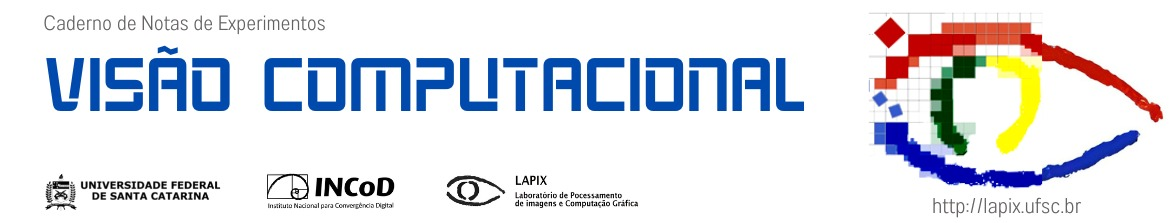






<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/06.2.Segmenta%C3%A7%C3%A3o%20por%20Crescimento%20de%20Regi%C3%B5es%20-%20Algoritmos%20Cl%C3%A1ssicos.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-green" alt="Python Version" title="Python Version"></a>

# 06.1.Segmentação por Crescimento de Regiões - Algoritmos Clássicos

O sonho de consumo de todo aquele que desenvolve métodos de processamento de imagens é um algoritmo genérico para dividir a imagem em seus componentes. Para conseguir fazer isso, os algoritmos clássicos de segmentação baseiam-se em informação de semelhança entre os pixels e de continuidade de valores de pixels dentro da imagem (veja a minha digressão sobre *apriorismos Kantianos* na vídeoaula inicial onde eu apresento os domínios e as etapas da visão computacional), sendo provavelmente os algoritmos que de forma mais icônica incorporam o conceito de "domínio do espaço". 

Infelizmente nenhum dos algoritmos clássicos de segmentação realiza esse sonho de consumo: um algoritmo clássico que se baseia unicamente na informação contida dentro da imagem necessariamente é um algoritmo que usa apenas informação de natureza *sintática*. Toda a informação que está à disposição do algoritmo de segmentação diz respeito apenas à própria natureza da *estrutura* (sintaxe) dos pixels: seus valores, suas posições relativas uns aos outros e seus padrões de variação no espaço. Como nenhum desses algoritmos incorpora a informação *semântica*, do significado de padrões de variação e organização, todos eles necessariamente vão dividir a imagem em regiões "parecidas", ignorando o fato de que um carro vermelho possui pneus pretos e faróis e para-choque prateados… Durante 50 anos da história da visão computacional, o pesadelo recorrente do desenvolvedor de algoritmos de interpretação de imagens foi o de juntar estes segmentos contendo paralama, capô, pneu, calota, para-choque, etc para formar uma imagem de um "automóvel". Na visão clássica isso só é possível de se fazer possuindo-se um *modelo* de qual é a aparência desse "automóvel". Essa informação, de caráter semântico, em muito extrapola o que um algoritmo de segmentação consegue fazer. 

Tentativas de resolver esse problema através de um pós-processamento utilizando-se técnicas da Inteligência Artificial Simbólica Clássica Baseada em Modelos (*Model Based Reasoning*) fracassaram para todos os domínios de aplicação que fugiam do trivialmente simples. A visão computacional só conseguiu vencer essa barreira com o advento da Segmentação Semântica utilizando Redes Neurais de Aprendizado Profundo nos últimos anos. Vamos ver isso quando chegarmos nesse capítulo. Por enquanto, divirta-se com os algoritmos clássicos que foram o estado da arte durante quase 50 anos da história da visão computacional…


### Checking where you're running...
GPU and PATH

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch

# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    ![ -d vision ] || git clone https://github.com/awangenh/vision
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [7] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

/home/awangenh/Documents/Aulas/VC/vision/jupyter
Linux note 6.2.0-36-generic #37~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Oct  9 15:34:04 UTC 2 x86_64 x86_64 x86_64 GNU/Linux
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.3 LTS"
Running on Google Colab =  False


#### Move the *data* folder

Move ***vision/data*** one level up, into the root folder, so the Anconda-oriented data paths in the next cells will all work properly. If you are running this notebook from a copy of the ***vision*** Git on Anaconda, you **do not** have to do this.

In [ ]:
if  _ON_COLAB:
    # If you are Running on Google Colab,
    # Move vision/data one level up, into the root folder
    !mv vision/data ..
!ls -al ..

total 20
drwxr-xr-x 1 root root 4096 Nov  3 18:20 .
drwxr-xr-x 1 root root 4096 Nov  3 18:21 ..
drwxr-xr-x 4 root root 4096 Nov  2 13:23 .config
drwxr-xr-x 1 root root 4096 Nov  2 13:24 sample_data
drwxr-xr-x 7 root root 4096 Nov  3 18:21 vision
mv: cannot stat 'vision/data': No such file or directory
total 116
drwxr-xr-x   1 root root  4096 Nov  3 18:21 .
drwxr-xr-x   1 root root  4096 Nov  3 18:21 ..
lrwxrwxrwx   1 root root     7 Jun  5 14:02 bin -> usr/bin
drwxr-xr-x   2 root root  4096 Apr 18  2022 boot
drwxr-xr-x   1 root root  4096 Nov  3 18:20 content
-rw-r--r--   1 root root  4332 Jun 21 00:40 cuda-keyring_1.0-1_all.deb
drwxr-xr-x   8 root root  4096 Nov  3 18:20 data
drwxr-xr-x   1 root root  4096 Nov  2 13:40 datalab
drwxr-xr-x   5 root root   360 Nov  3 18:19 dev
-rwxr-xr-x   1 root root     0 Nov  3 18:19 .dockerenv
drwxr-xr-x   1 root root  4096 Nov  3 18:19 etc
drwxr-xr-x   2 root root  4096 Apr 18  2022 home
lrwxrwxrwx   1 root root     7 Jun  5 14:02 lib -> usr/lib
lrw

#### Mount your Google Drive as a Folder

If you're using Google Colab together with your Google Drive, adapt this code below to point to the place where you've copied our Git in your Google Drive:

In [ ]:
# Code to mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Look at the contents of your Drive:

In [ ]:
!ln -s "/content/drive/My Drive"

### Initializations

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

## K-Means

The traditional cluster analysis algorithm applied to image segmentaion: similar pixels that are in neighbouring regions are clustered into regions.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, interact_manual
from skimage.data import astronaut
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

image = cv2.imread("../data/ct-02.jpg", cv2.IMREAD_GRAYSCALE)
#image = img_as_float(img[::2, ::2])


def my_k_means(n_segments, compactness, sigma, colormap):
    global image
    colormap = eval('plt.cm.' + colormap)
    segments_slic = slic(image, n_segments=n_segments, compactness=compactness, sigma=sigma, channel_axis=None)

    fig, ax = plt.subplots(ncols=2, figsize=(15, 7), sharex=True, sharey=True)

    ax[0].imshow(mark_boundaries(image, segments_slic))
    ax[0].set_title('Original with Boundaries: SLIC (k-Means)')

    ax[1].imshow(segments_slic, cmap=colormap, interpolation='nearest')
    ax[1].set_title('Segments: SLIC (k-Means)')

    for a in ax:
        a.set_axis_off()


    plt.tight_layout()
    plt.show()

interactive(my_k_means, n_segments=(5, 100), compactness=(0.1, 1.0), sigma=(0.1, 3.0), colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])

interactive(children=(IntSlider(value=52, description='n_segments', min=5), FloatSlider(value=0.55, descriptio…

## Watershed

The watershed is a classical algorithm used for segmentation, that is, for separating different objects in an image.

Starting from user-defined markers, the watershed algorithm treats pixels values as a local topography (elevation). The algorithm floods basins from the markers, until basins attributed to different markers meet on watershed lines. In many cases, markers are chosen as local minima of the image, from which basins are flooded. One good explanation of the Watershed Transform is provided at the page of the Centre for Mathematical Morphology, the image processing laboratory of MINES ParisTech: http://www.cmm.mines-paristech.fr/~beucher/wtshed.html. Theanimation below is from there:

![](http://www.cmm.mines-paristech.fr/~beucher/lpe1.gif)

### Doing Watershed with SciKit

In the example below, two overlapping circles are to be separated. To do so, one computes an image that is the distance to the background. The maxima of this distance (i.e., the minima of the opposite of the distance) are chosen as markers, and the flooding of basins from such markers separates the two circles along a watershed line.

In [5]:
import numpy as np
from ipywidgets import interact, interactive, interact_manual
import cv2, scipy
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.feature import canny
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import felzenszwalb, slic, quickshift, watershed

#from skimage.morphology import watershed
from skimage.feature import peak_local_max


image = cv2.imread("../data/ct-02.jpg", cv2.IMREAD_GRAYSCALE)
# shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)

gradient_methods = [
    'None',
    'Sobel',
    'Canny'
]

def my_watershed(gradient_method, markers, colormap):
    global image
    colormap = eval('plt.cm.' + colormap)
    
    if (gradient_method == 'None'):
        input_image = image
    elif (gradient_method == 'Sobel'):
        input_image = sobel(image)
    else:
        input_image = canny(image)

    # Generate the markers as local maxima of the distance to the background
    # Apply Exact euclidean distance transform
    distance = ndi.distance_transform_edt(image)
    # The peak_local_max function returns the coordinates of local peaks (maxima) in an image. 
    # A maximum filter is used for finding local maxima. This operation dilates the original 
    # image and merges neighboring local maxima closer than the size of the dilation. 
    # Coordinates where the original image is equal to the dilated image are returned as local maxima.
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((8,8)), labels=image, min_distance=20)
    # Take the number...
    #markers = ndi.label(local_maxi)[0]
    #labels = watershed(-distance, markers, mask=image)
    labels = watershed(input_image, markers=markers, connectivity=1, compactness=0.0, watershed_line=True)

    fig, axes = plt.subplots(ncols=3, figsize=(20, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow((mark_boundaries(image, labels)), cmap=plt.cm.gray)
    ax[0].set_title('Original with Boundaries')
    if (gradient_method == 'None'):
        #ax[1].imshow(distance, cmap=plt.cm.gray, interpolation='nearest')
        ax[1].imshow(distance, cmap=plt.cm.gray)
        ax[1].set_title('Distances')
        # Plot the local maxima...
        ax[1].autoscale(False)
        ax[1].plot(local_maxi[:, 1], local_maxi[:, 0], 'r.')
    else:
        ax[1].imshow(input_image, cmap=plt.cm.gray)
        ax[1].set_title(gradient_method)

    ax[2].imshow(labels, cmap=colormap, interpolation='nearest')
    ax[2].set_title('Regions')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    
interact_manual(my_watershed, gradient_method=gradient_methods, markers = (0, 100), colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])

interactive(children=(Dropdown(description='gradient_method', options=('None', 'Sobel', 'Canny'), value='None'…

<function __main__.my_watershed(gradient_method, markers, colormap)>

### Alternative Watershed

This is Martin Zurowietz's somehow minimalist implementation of ***Pierre Soille, Luc M. Vincent***, *"Determining watersheds in digital pictures via flooding simulations"*, Proc. SPIE 1360, Visual Communications and Image Processing'90: Fifth in a Series, (1 September 1990); doi: 10.1117/12.24211; http://dx.doi.org/10.1117/12.24211. The orignal code is on https://github.com/mzur/watershed. In contrast to [`skimage.morphology.watershed`](http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.watershed) and [`cv2.watershed`](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html) this implementation does not use marker seeds. We're using my mirror, https://github.com/awangenh/watershed, where I adapted the code to Python 3.

![source image](https://raw.githubusercontent.com/awangenh/watershed/master/w2.png)

In [ ]:
# Do this once (or each time you restart the kernel if you're using Colab)
# Code below downloads the Python 3 version stored in my mirror
# wget parameters: 
# --backups=1 : renames original file with .1 suffix and writes new file to the intended filename
# -q : run quiet unless there's an error
!wget  --backups=1 -q https://raw.githubusercontent.com/awangenh/watershed/master/Watershed.py

file_path = "/content/Watershed.py"

target = "neighbours = np.array([self._get_neighbors(height, width, p) for p in pixels])"
replacement_lines = [
    "neighbours = np.array([self._get_neighbors(height, width, p) for p in pixels], dtype=object)\n",
    "neighbours = neighbours.reshape((height, width))\n"
]

with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

for i, line in enumerate(lines):
    if target in line:
        indent = line[:len(line) - len(line.lstrip())]
        lines[i:i+1] = [indent + replacement_lines[0], indent + replacement_lines[1]]
        break

with open(file_path, 'w', encoding='utf-8') as f:
    f.writelines(lines)

# !cat {file_path}

In [ ]:
from ipywidgets import interact, interactive, interact_manual
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#from scipy.misc import imsave
from Watershed import *

def my_alt_watershed(colormap):
    colormap = eval('plt.cm.' + colormap)
    w = Watershed()
    image = Image.open("../data/ct-02.jpg")
    npArray = np.array(image)
    labels = w.apply(npArray)
    fig, axes = plt.subplots(ncols=2, figsize=(20, 8), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(image)
    ax[0].set_title('Original')

    # Plot regions using selected colormap...
    ax[1].imshow(labels, cmap=colormap, interpolation='nearest')
    ax[1].set_title('Regions')
    for a in ax:
        a.set_axis_off()
    fig.tight_layout()
    plt.show()

# This implementation has no parameters and no interaction!
interact_manual(my_alt_watershed, colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])

interactive(children=(Dropdown(description='colormap', options=('nipy_spectral', 'hot', 'magma', 'seismic'), v…

### Watershed in OpenCV

Watershed in OpenCV is not better than in Skimage and depends strongly on a previous selection of seeding points that cannot be selected by simply running an edge detection algorithm. This is not convenient. Howerver, lots of people offer variations of the original example in the OpenCV docus. Here are some:
- https://www.pyimagesearch.com/2015/11/02/watershed-opencv/
- https://docs.opencv.org/3.3.1/d3/db4/tutorial_py_watershed.html
- https://stackoverflow.com/questions/11294859/how-to-define-the-markers-for-watershed-in-opencv

We will repeat the standard example using coins and markers. The code I use is inspired on Adrian Rosebrock's version (above) available at pyImageSearch. Observe that the final "magic" contours are given with the assumption that the objects areall round, which is a thing you should not endeavor...

[INFO] 1 unique contours found
[INFO] 16 unique segments found


/tmp/ipykernel_37044/3756945967.py:39: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=20, labels=thresh)


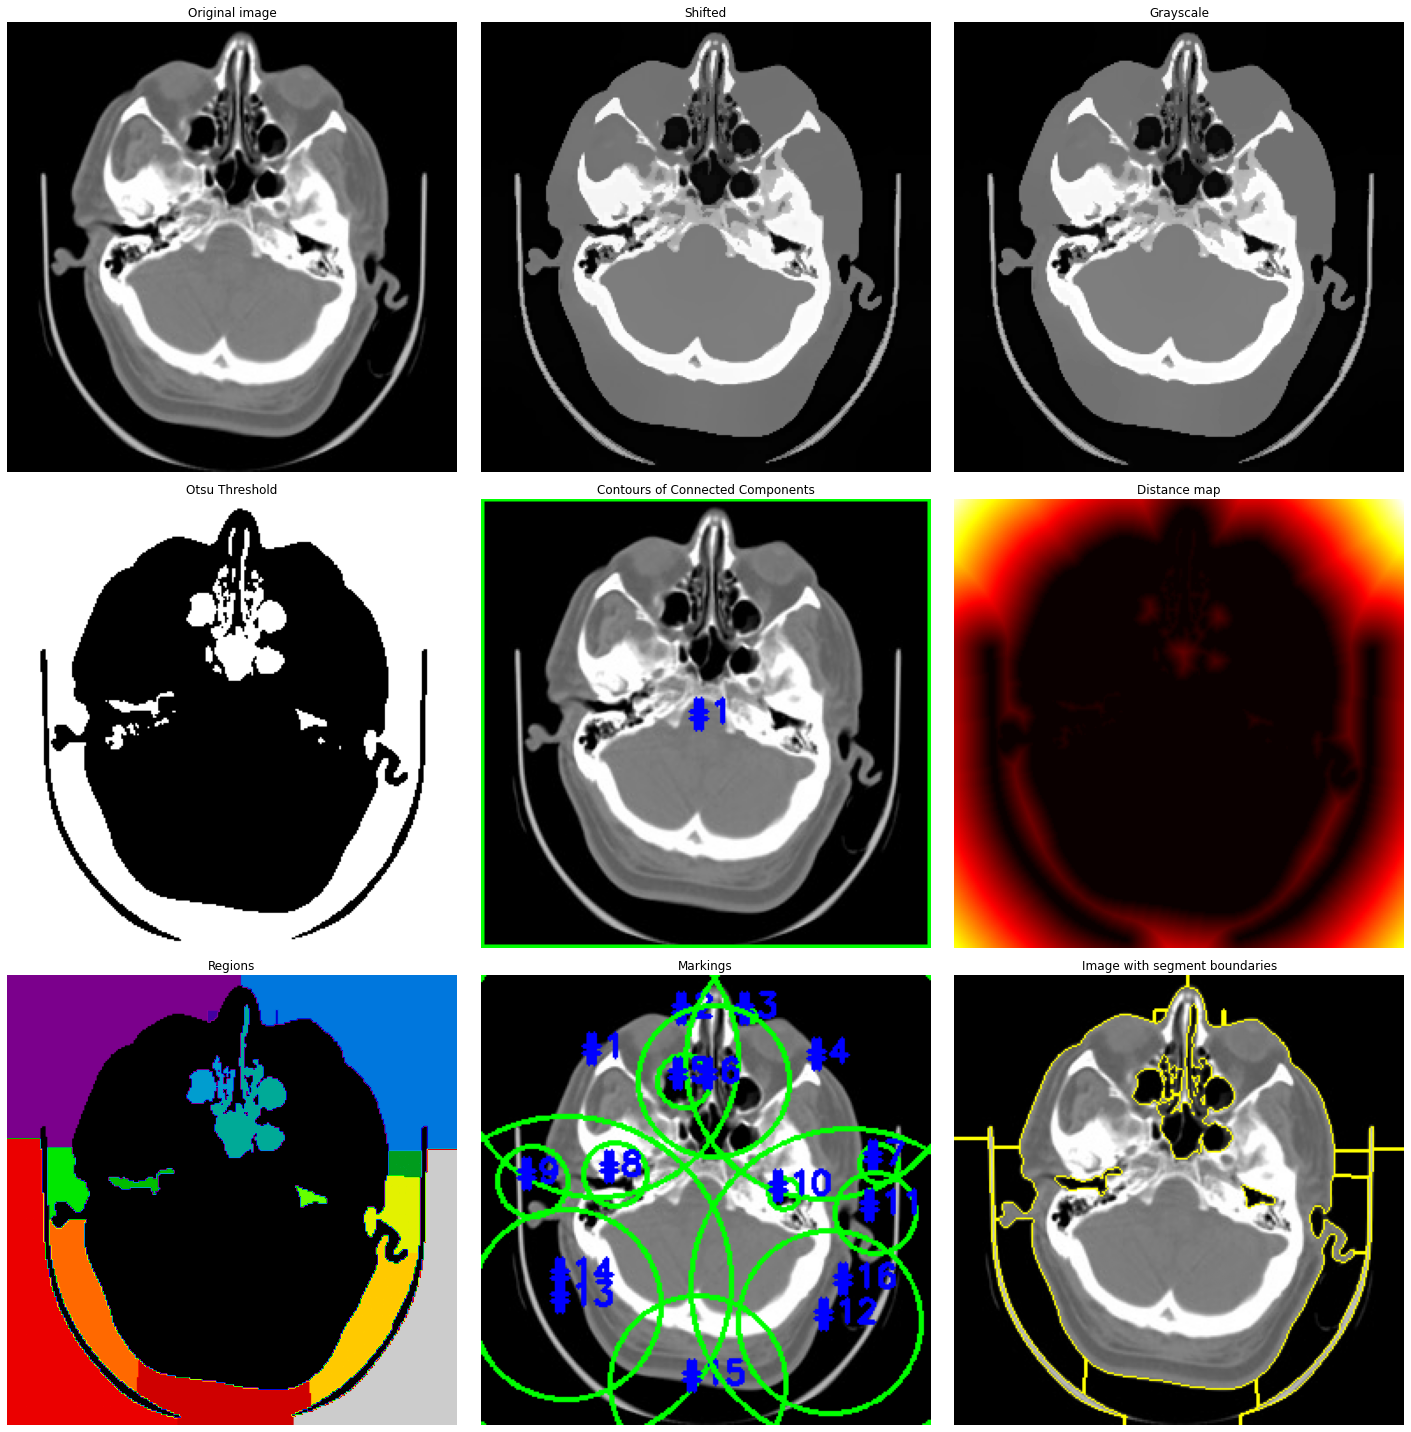

In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import cv2
import imutils
import copy

# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
#image = cv2.imread("../data/coins-01.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)

# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Since in this case the background is lighter than the coins, you'll have to invert the threshold image
thresh = cv2.bitwise_not(thresh)

# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
print("[INFO] {} unique contours found".format(len(cnts)))

contours = copy.deepcopy(image)
# loop over the contours
for (i, c) in enumerate(cnts):
    # draw the contour
    ((x, y), _) = cv2.minEnclosingCircle(c)
    cv2.putText(contours, "#{}".format(i + 1), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.drawContours(contours, [c], -1, (0, 255, 0), 2)

# Watershed precalculations
# compute the exact Euclidean distance from every binary pixel to the nearest zero pixel, then find peaks in this distance map
D = ndimage.distance_transform_edt(thresh)

# local max coordcinates
localMax_coords = peak_local_max(D, min_distance=20, labels=thresh)
# creates a array to receive the results
localMax = np.zeros_like(D, dtype=bool)
# set True to local peaks
localMax[tuple(localMax_coords.T)] = True
 
# perform a connected component analysis on the local peaks, using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
# finally call Watershed!
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

# loop over the unique labels returned by the Watershed algorithm
water = copy.deepcopy(image)
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue

    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(water, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(water, "#{}".format(label), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)


fig, axes = plt.subplots(nrows = 3,ncols=3, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(shifted, cmap=plt.cm.gray)
ax[1].set_title('Shifted')

ax[2].imshow(gray, cmap=plt.cm.gray)
ax[2].set_title('Grayscale')

ax[3].imshow(thresh, cmap=plt.cm.gray)
ax[3].set_title('Otsu Threshold')

ax[4].imshow(contours)
ax[4].set_title('Contours of Connected Components')

ax[5].imshow(D, cmap=plt.cm.hot)
ax[5].set_title('Distance map')

ax[6].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[6].set_title('Regions')

ax[7].imshow(water, cmap=plt.cm.nipy_spectral)
ax[7].set_title('Markings')

ax[8].imshow(mark_boundaries(image, labels), cmap=plt.cm.gray)
ax[8].set_title('Image with segment boundaries')



for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()


## Variational Methods: Mumford & Shah Functional

In stead of the original M&S, we'll be using the *Ambrosio Tortorelli Minimizer variant* as implemented by Jacob Gildenblat (jacob.gildenblat@gmail.com). For the sake of simplicity, we'll call it **A&Tmin** in this lecture. Jacob's CV blog is here: https://jacobgil.github.io/

### Import things you'll need for both grayscale & color

We will process images differently depending on if they're colored or not, but this here you'll need anyway. 

In [ ]:
# Do this once (or each time you restart the kernel if you're using Colab)
# Code below downloads the version stored in my mirror
# wget parameters: 
# --backups=1 : renames original file with .1 suffix and writes new file to the intended filename
# -q : run quiet unless there's an error
!wget --backups=1 -q https://raw.githubusercontent.com/awangenh/Ambrosio-Tortorelli-Minimizer/master/AmbrosioTortorelliMinimizer.py

file_path = "/content/AmbrosioTortorelliMinimizer.py"

targets = [
    "self.edges, _ = scipy.sparse.linalg.cg(A, b, tol = self.tol, maxiter = self.maxiter)",
    "self.f, _ = scipy.sparse.linalg.cg(A, b, tol = self.tol, maxiter = self.maxiter)"
]

replacements = [
    "self.edges, _ = scipy.sparse.linalg.cg(A, b, atol = self.tol, maxiter = self.maxiter)",
    "self.f, _ = scipy.sparse.linalg.cg(A, b, atol = self.tol, maxiter = self.maxiter)"
]

with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

for target, replacer in zip(targets, replacements):
    for i, line in enumerate(lines):
        if target in line:
            indent = line[:len(line) - len(line.lstrip())]
            lines[i] = indent + replacer + '\n'
            break

with open(file_path, 'w', encoding='utf-8') as f:
    f.writelines(lines)

# !cat {file_path}

In [8]:
from ipywidgets import interact, interactive, interact_manual
import cv2, scipy
from skimage import data
from matplotlib import pyplot as plt
# Import the M&S-equivalent Ambrosio Tortorelli Minimizer (we'll call it A&Tmin)
# You have to download it before from https://github.com/jacobgil/Ambrosio-Tortorelli-Minimizer
# or from my mirror (is NOT updated): https://github.com/awangenh/Ambrosio-Tortorelli-Minimizer
from AmbrosioTortorelliMinimizer import *

### A&Tmin for Grayscale Images

In [9]:
# image = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.imread("../data/ct-02.jpg", cv2.IMREAD_GRAYSCALE)

def my_ATmin(iterations, solver_maxiterations, tol, alpha, beta, epsilon, colormap):
    global image
    colormap = eval('plt.cm.' + colormap)
    solver = AmbrosioTortorelliMinimizer(image, iterations, solver_maxiterations, tol, alpha, beta, epsilon)
    seg, edges = solver.minimize()

    fig, axes = plt.subplots(ncols=3, figsize=(20, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original image')

    ax[1].imshow(edges, cmap=plt.cm.gray)
    ax[1].set_title('Edges')

    ax[2].imshow(seg, cmap=colormap)
    ax[2].set_title('Result')

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

interact_manual(my_ATmin, iterations = (1, 100, 1), solver_maxiterations = (1, 100), tol = (0.01, 1.0), alpha = (100, 10000, 100), 
                beta = (0.001, 0.1, 0.001), epsilon = (0.001, 0.1, 0.001), colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])
# Default values: iterations = 1, solver_maxiterations = 10, tol = 0.1, alpha = 1000, beta = 0.01, epsilon = 0.01

interactive(children=(IntSlider(value=50, description='iterations', min=1), IntSlider(value=50, description='s…

<function __main__.my_ATmin(iterations, solver_maxiterations, tol, alpha, beta, epsilon, colormap)>

### A&Tmin for Color Images

Jacob Gildenblat's implementation is a one-channel implementation. It's not really suited for color images,but we can, as the author himself demonstrates, use it for color images employing the dirty hack of processing the color channels independently and then using a maxima-approach for the edges:

In [10]:
image = cv2.imread("../data/car-01.jpg", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def my_ColorATmin(iterations, solver_maxiterations, tol, alpha, beta, epsilon):
    global image
    # Create empty lists for the partialresults
    seg, edges = [], []
    # Split image by channels (R, G, B)
    for channel in cv2.split(image):
        solver = AmbrosioTortorelliMinimizer(channel, iterations, solver_maxiterations, tol, alpha, beta, epsilon)
        channel_seg, channel_edges = solver.minimize()
        # Append channel-result to list
        seg.append(channel_seg)
        edges.append(channel_edges)

    # Merge channels into a 3-channel segmented image
    segments = cv2.merge(seg)
    # Take the maximum of each channel to be the edge pixel
    edges = np.maximum(*edges)
        
    fig, axes = plt.subplots(ncols=3, figsize=(20,8))
    ax = axes.ravel()

    ax[0].imshow(image)
    ax[0].set_title('Original image')

    ax[1].imshow(segments)
    ax[1].set_title('Result')

    ax[2].imshow(edges, cmap=plt.cm.gray)
    ax[2].set_title('Edges')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

# Default values: iterations = 1, solver_maxiterations = 10, tol = 0.1, alpha = 1000, beta = 0.01, epsilon = 0.01
interact_manual(my_ColorATmin, iterations = (1, 100, 1), solver_maxiterations = (1, 100), tol = (0.01, 1.0), alpha = (100, 10000, 100), 
                beta = (0.001, 0.1, 0.001), epsilon = (0.001, 0.1, 0.001))
None

interactive(children=(IntSlider(value=50, description='iterations', min=1), IntSlider(value=50, description='s…

# Credits

* The Watershed section was partially based upon material available at:
  * https://www.pyimagesearch.com/2015/11/02/watershed-opencv/
  * https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html
  * https://docs.opencv.org/3.4.3/d3/db4/tutorial_py_watershed.html
* The Mumford & Shah section was partially based upon material available at:
  * The excellent and innovative Python implementation of the Ambrosio-Tortorelli-Minimizer variant of M&S at: https://github.com/jacobgil/Ambrosio-Tortorelli-Minimizer
  * The documentation of the Ambrosio-Tortorelli-Minimizer variant of M&S at: https://jacobgil.github.io/computervision/mumford-shah and http://jacobcv.blogspot.com/2015/04/smoothing-images-with-mumford-shah.html
* General tricks for displaying images were from here: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html
* We also used a few general tips from: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py

![banner cnns ppgcc ufsc](https://lapix.ufsc.br/wp-content/uploads/2022/10/rodape-CC.png)